In [8]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
from scipy.io import wavfile
%matplotlib inline
plt.style.use('default')

In [9]:
def remove_vocals_dsp(y, sr):
    """Simplified version optimized for notebook visualization"""
    # 1. Center Channel Cancellation (if stereo)
    if len(y.shape) == 2:
        y_mono = np.mean(y, axis=0)
    else:
        y_mono = y
    
    # 2. Spectral Processing
    D = librosa.stft(y_mono, n_fft=512)
    S_db = librosa.amplitude_to_db(np.abs(D))
    
    # Create frequency mask for vocal range
    freq_bins = librosa.fft_frequencies(sr=sr, n_fft=512)
    vocal_mask = np.ones_like(S_db)
    
    # Define vocal ranges and their reduction factors
    vocal_ranges = [
        (200, 800, 0.4),    # Lower vocals
        (800, 2600, 0.3),   # Main vocal range
        (2600, 4000, 0.5)   # Upper harmonics
    ]
    
    # Apply different reduction factors to different ranges
    for low, high, reduction in vocal_ranges:
        range_mask = (freq_bins >= low) & (freq_bins <= high)
        vocal_mask[range_mask] = reduction
    
    # Apply mask
    S_masked = S_db * vocal_mask
    y_masked = librosa.db_to_amplitude(S_masked)
    y_reduced = librosa.istft(y_masked * np.exp(1j * np.angle(D)))
    
    return y_reduced, vocal_mask

In [10]:
def plot_audio_and_spec(y, sr, title=""):
    plt.figure(figsize=(15, 8))
    
    # Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")
    
    plt.tight_layout()
    plt.show()

Loaded audio: 22050Hz sampling rate, 10.00 seconds


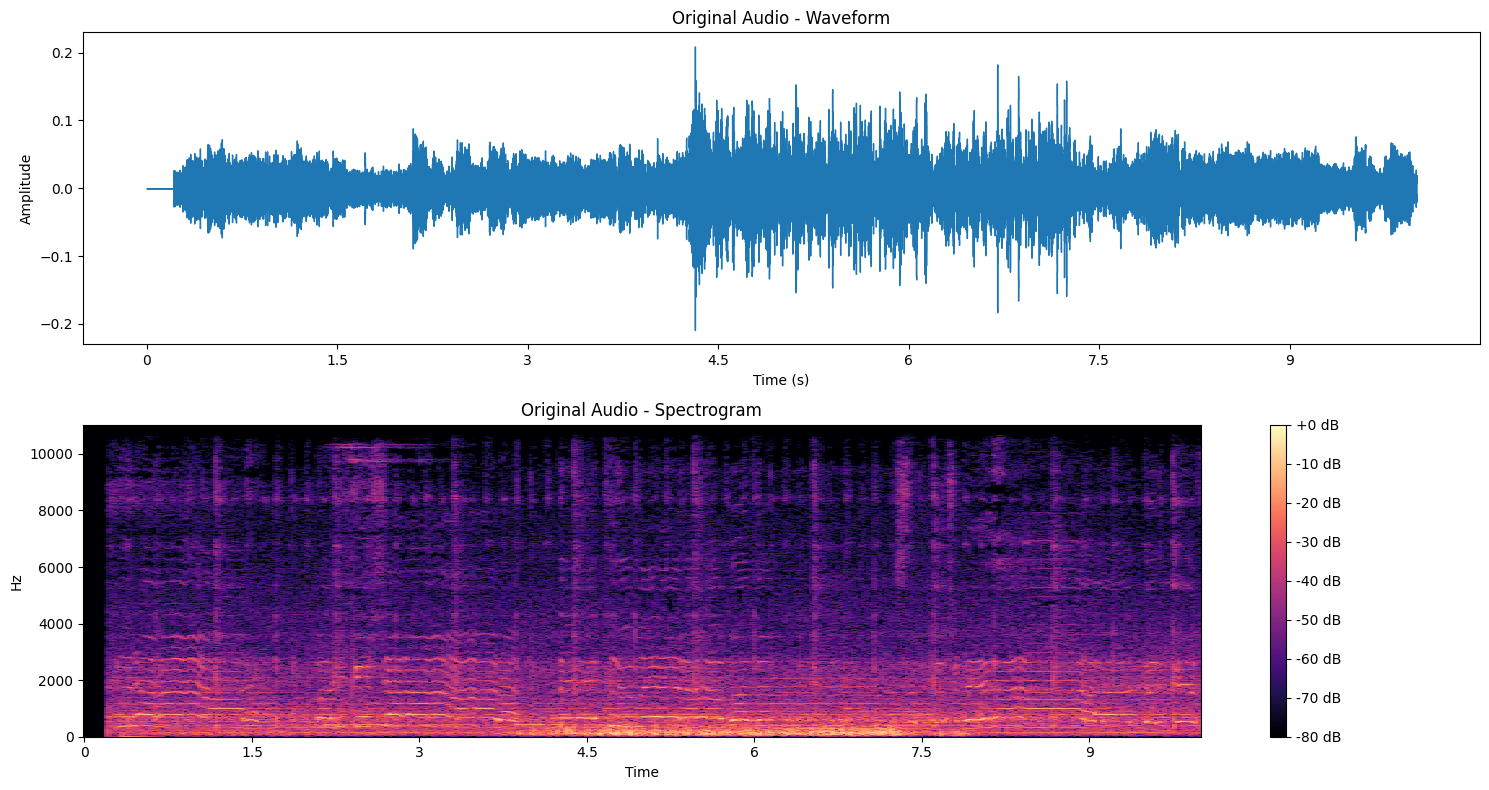

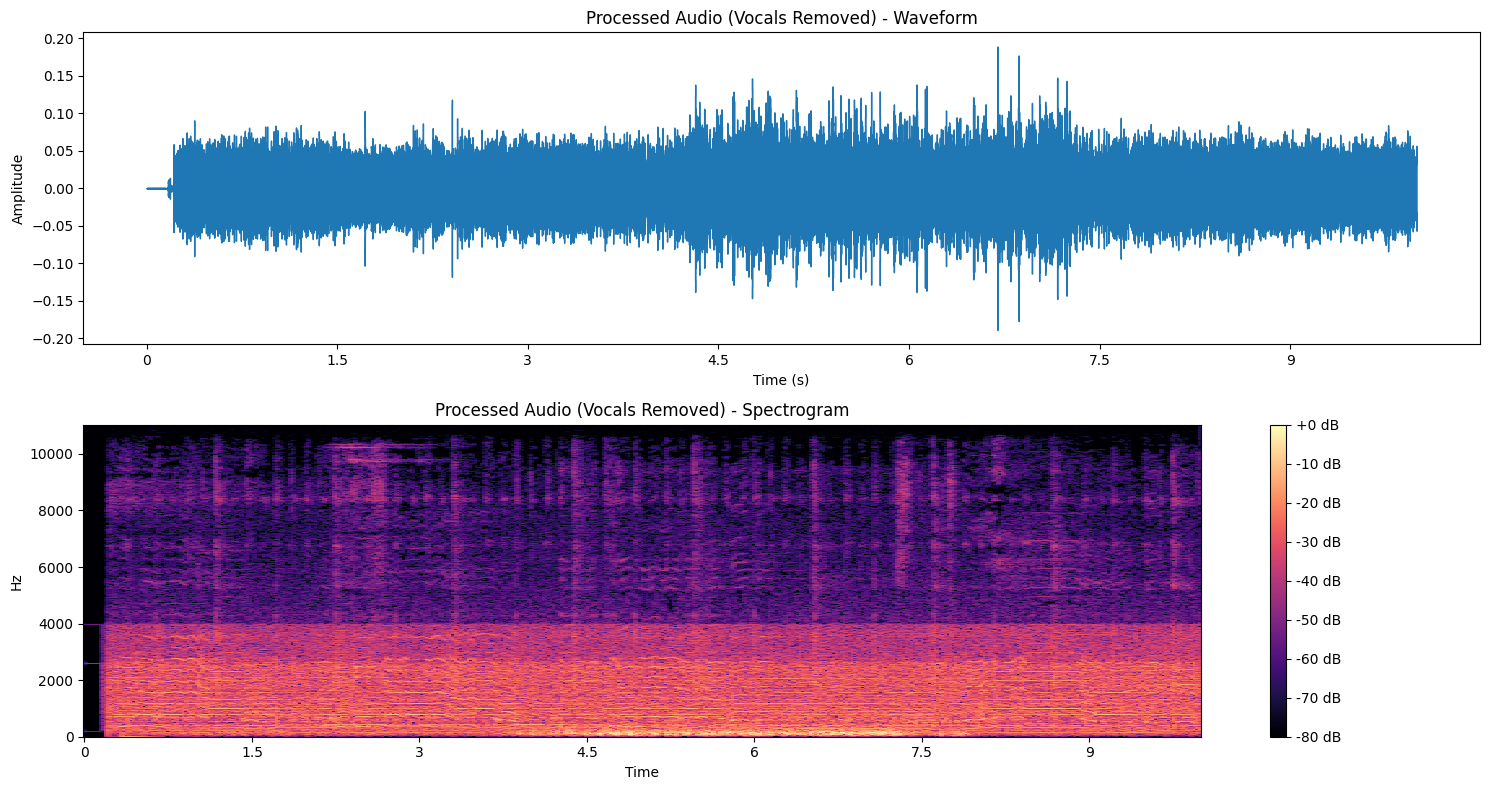

In [11]:
audio_path = 'infer3.mp3'
y, sr = librosa.load(audio_path, duration=10)  # Load first 10 seconds for demo
print(f"Loaded audio: {sr}Hz sampling rate, {len(y)/sr:.2f} seconds")

# Display original audio waveform and spectrogram
plot_audio_and_spec(y, sr, "Original Audio")

# Play original audio
ipd.display(ipd.Audio(y, rate=sr))

# Cell 5: Process and remove vocals
y_processed, vocal_mask = remove_vocals_dsp(y, sr)

# Display processed audio
plot_audio_and_spec(y_processed, sr, "Processed Audio (Vocals Removed)")

# Play processed audio
ipd.display(ipd.Audio(y_processed, rate=sr))

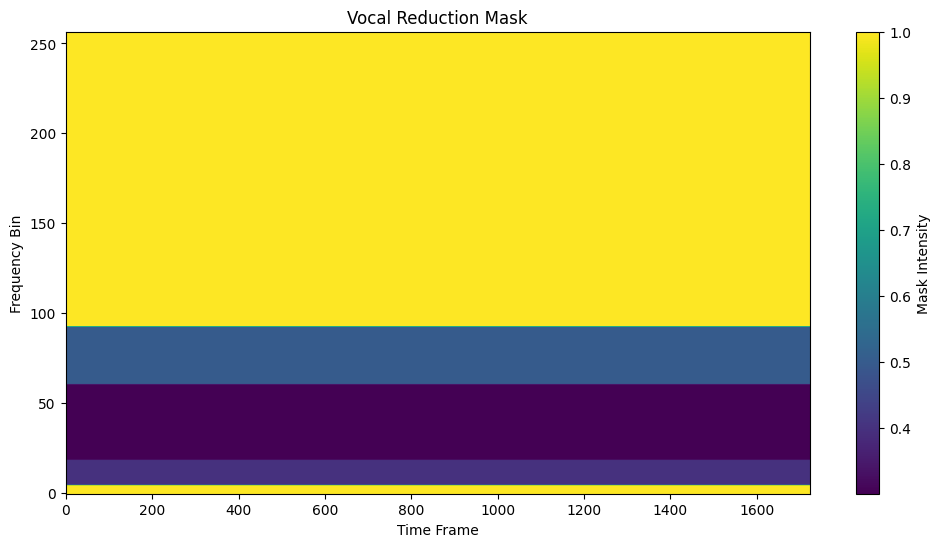

In [12]:
plt.figure(figsize=(12, 6))
freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2048)
plt.imshow(vocal_mask, aspect='auto', origin='lower')
plt.colorbar(label='Mask Intensity')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.title('Vocal Reduction Mask')
plt.show()

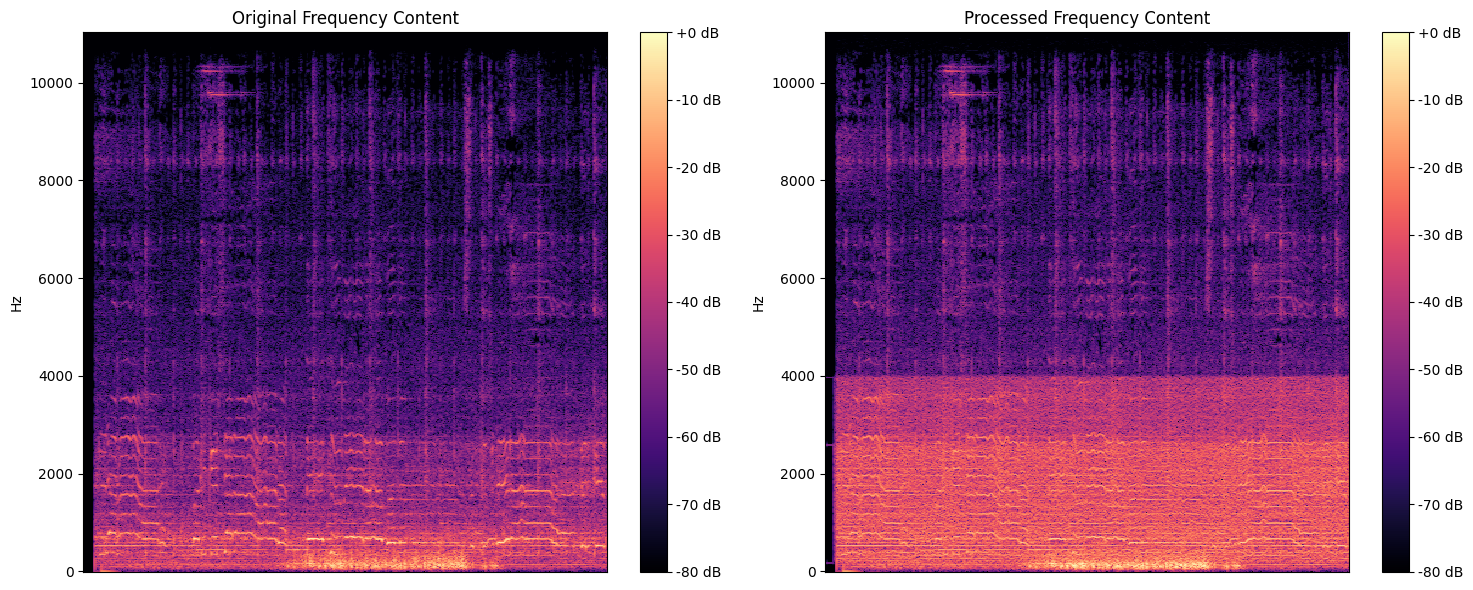

In [13]:
def plot_frequency_comparison(y_orig, y_proc, sr):
    plt.figure(figsize=(15, 6))
    
    # Compute power spectra
    S_orig = np.abs(librosa.stft(y_orig))
    S_proc = np.abs(librosa.stft(y_proc))
    
    # Convert to dB
    S_orig_db = librosa.amplitude_to_db(S_orig, ref=np.max)
    S_proc_db = librosa.amplitude_to_db(S_proc, ref=np.max)
    
    # Plot
    plt.subplot(1, 2, 1)
    librosa.display.specshow(S_orig_db, sr=sr, y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Frequency Content')
    
    plt.subplot(1, 2, 2)
    librosa.display.specshow(S_proc_db, sr=sr, y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Processed Frequency Content')
    
    plt.tight_layout()
    plt.show()

plot_frequency_comparison(y, y_processed, sr)


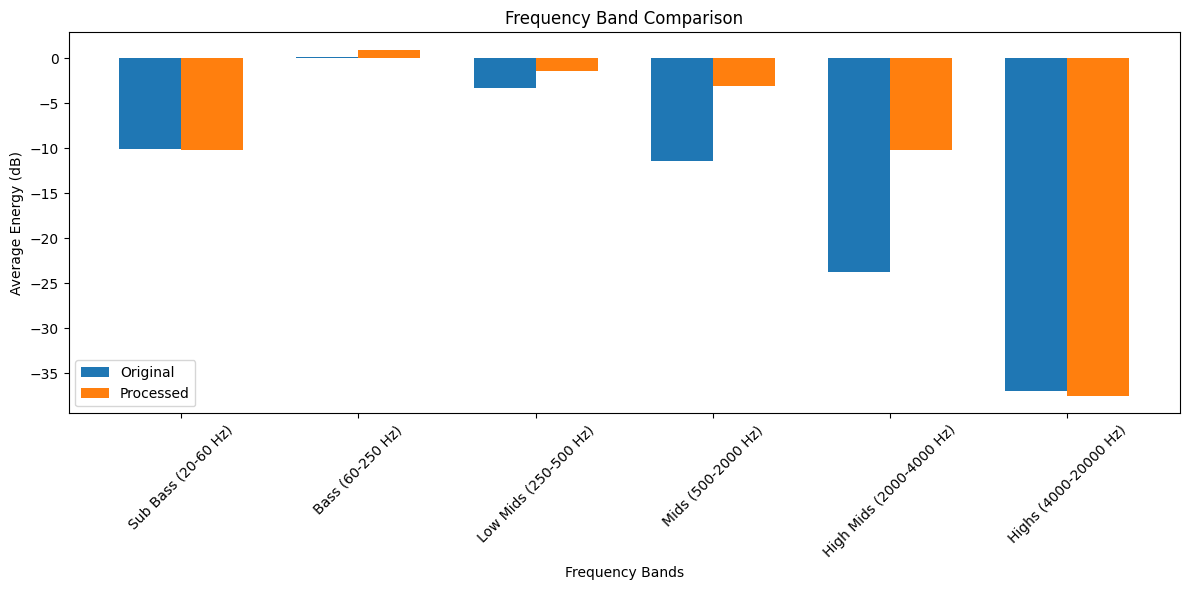

In [14]:
def analyze_frequency_bands(y, sr):
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D))
    freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2048)
    
    bands = {
        'Sub Bass (20-60 Hz)': (20, 60),
        'Bass (60-250 Hz)': (60, 250),
        'Low Mids (250-500 Hz)': (250, 500),
        'Mids (500-2000 Hz)': (500, 2000),
        'High Mids (2000-4000 Hz)': (2000, 4000),
        'Highs (4000-20000 Hz)': (4000, 20000)
    }
    
    results = {}
    for band_name, (low, high) in bands.items():
        mask = (freq_bins >= low) & (freq_bins <= high)
        band_energy = np.mean(S_db[mask])
        results[band_name] = band_energy
    
    return results

# Analyze both original and processed audio
orig_analysis = analyze_frequency_bands(y, sr)
proc_analysis = analyze_frequency_bands(y_processed, sr)

# Plot comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(orig_analysis))
width = 0.35

plt.bar(x - width/2, list(orig_analysis.values()), width, label='Original')
plt.bar(x + width/2, list(proc_analysis.values()), width, label='Processed')

plt.xlabel('Frequency Bands')
plt.ylabel('Average Energy (dB)')
plt.title('Frequency Band Comparison')
plt.xticks(x, list(orig_analysis.keys()), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()